## RBFs reconstruction of historical and synthetic data

inputs required: 
  * Synthetic offshore waves - emulator output
  * Sea and swell **SWAN simulated cases**

in this notebook:
  * RBF reconstruction simulated storms
  * Generation of hourly nearshore waves with Intradaily Hydrographs



### Workflow:

<div>
<img src="../resources/nb02_03.png" width="400px">
</div>



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import pickle as pkl
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..',  '..'))

# teslakit
from teslakit.database import Database, hyswan_db
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL, Intradaily_Hydrograph, Snell_Propagation
from teslakit.climate_emulator import Climate_Emulator
from teslakit.util.time_operations import repair_times_hourly, add_max_storms_mask



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/laurac/Dropbox/Majuro_training/teslakit/DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO-training')

# hyswan simulation database
db_sim = hyswan_db(db.paths.site.HYSWAN.sim)
nsims=2

vns_ds=['sea_Hs', 'swell_1_Hs', 'swell_2_Hs', 'swell_3_Hs',
'sea_Tp', 'swell_1_Tp', 'swell_2_Tp', 'swell_3_Tp', 
'sea_Dir', 'swell_1_Dir', 'swell_2_Dir', 'swell_3_Dir','level']

In [3]:
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

Subset

In [4]:
levels=[-1.25, 0, 1.25, 2.5]
level=np.repeat(levels,500)

In [5]:
subset=xr.open_dataset(os.path.join(p_data, 'sites', 'MAJURO-training', 'MDA_Selection_500_originalSPC.nc'))
subset=subset.to_dataframe()
subset = pd.concat([subset] * 4)
subset=subset.reset_index().drop(columns=['storm'])
subset['level']=level
subset=subset[vns_ds]
subset

,sea_Hs,swell_1_Hs,swell_2_Hs,swell_3_Hs,sea_Tp,swell_1_Tp,swell_2_Tp,swell_3_Tp,sea_Dir,swell_1_Dir,swell_2_Dir,swell_3_Dir,level
0,4.019669,0.552857,0.066276,0.375683,9.636809,12.265589,15.675636,11.960863,14.655715,306.450531,30.775490,156.855530,-1.25
1,0.232469,0.534497,0.975040,0.661276,6.292626,8.430457,10.677402,13.619751,213.060272,20.001028,120.751450,256.355408,-1.25
2,0.118347,4.675153,0.493241,0.520907,11.381059,11.009116,9.681247,9.288310,86.465698,336.912842,54.634865,197.347519,-1.25
3,1.997513,0.233245,4.787343,0.562118,11.640744,11.326648,8.420750,11.251611,32.421436,349.804260,123.472183,231.637680,-1.25
4,1.567944,0.121489,0.237711,0.602853,11.527353,11.112859,9.427955,10.543319,155.220779,184.401566,126.731140,199.876923,-1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.460053,3.575270,0.271900,1.540564,10.360985,13.824783,16.324137,13.768680,31.277647,344.339142,120.843521,179.742645,2.50
1996,1.290972,0.617225,0.299326,0.491496,7.868112,5.929164,17.752184,11.945197,201.415314,339.435150,34.997936,130.400864,2.50
1997,1.982033,0.553388,0.302102,0.492713,8.485591,13.923278,14.591935,9.752848,114.676743,282.286621,117.067055,237.656845,2.50
1998,1.935831,4.558166,0.923851,0.529271,5.839591,14.752662,10.673785,8.802774,21.198484,312.121155,126.921120,191.092499,2.50


In [6]:
target=xr.open_dataset(os.path.join('/Users/laurac/Dropbox/Majuro_training/teslakit/DATA/sites/MAJURO-training/HYSWAN/sim/','swl_target.nc')).to_dataframe()
target=target.dropna()
# Remove nans from target and keep subset for those indices
subset=subset.iloc[target.index].reset_index()
target=target.reset_index()
target

,case,hs,tm,tp,dir,level
0,0,3.313013,6.552694,9.377150,12.361633,-1.25
1,1,0.885519,5.401834,10.331567,104.043243,-1.25
2,2,2.787897,8.717952,10.850708,346.471191,-1.25
3,3,3.902647,7.447399,8.383430,113.499222,-1.25
4,4,1.312289,3.812934,11.267354,147.729980,-1.25
...,...,...,...,...,...,...
1983,1995,3.124679,10.186867,13.446346,350.178375,2.50
1984,1996,1.121564,2.686414,7.708216,78.485123,2.50
1985,1997,1.573625,6.660031,8.355042,114.595413,2.50
1986,1998,1.757135,4.619714,5.822991,32.799805,2.50


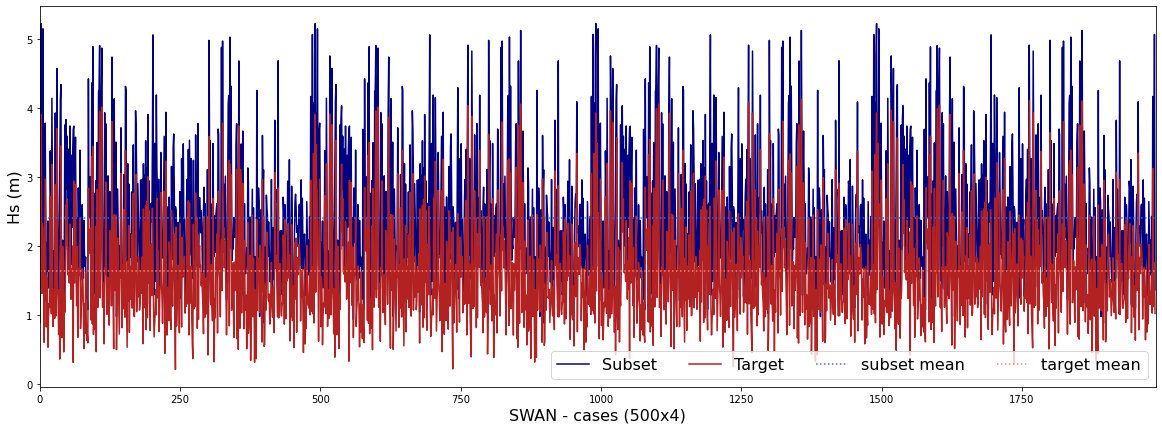

In [7]:
plt.figure(1, figsize=[20,7])

hs_subset=np.sqrt(subset.sea_Hs**2 + subset.swell_1_Hs**2 + subset.swell_2_Hs**2 + subset.swell_3_Hs**2)

plt.plot(hs_subset, '-', color='navy',label='Subset')
plt.plot(target.hs, '-', color='firebrick', label='Target')
plt.plot([0, len(hs_subset)], [np.nanmean(hs_subset), np.nanmean(hs_subset)], ':', color='royalblue', label='subset mean')
plt.plot([0, len(target.hs)], [np.nanmean(target.hs), np.nanmean(target.hs)], ':', color='salmon', label='target mean')

plt.xlim([0,len(hs_subset)])
c0=0 #Start case to plot
ce=len(hs_subset) #End case to plot
plt.xlim([c0, ce])

plt.ylabel('Hs (m)', fontsize=16)
plt.xlabel('SWAN - cases (500x4)', fontsize=16)
plt.legend(ncol=4, fontsize=16)

In [8]:
#Load dataset and add level values

dataset=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO-training','Dataset_'+str(nsims)+'simsmaxstorm.nc')).to_dataframe()
dataset=dataset.dropna().reset_index()
dwt=dataset['dwt']
mu_dat=dataset['mu']
tau_dat=dataset['tau']
hs_dat=dataset['Hs']
tp_dat=dataset['Tp']
dir_dat=dataset['Dir']

lvel, bmus = [], []
for s in range(nsims):
    l=xr.open_dataset(os.path.join(db.paths.site.SIMULATION.offshore + '/{:08d}'.format(s)+ '/TWL.nc'),
                                 decode_times=False).TWL.values
    l=np.append(l[0],l); l=np.append(l,l[-1])
    lvel=np.append(lvel,l)
    b=xr.open_dataset(os.path.join(db.paths.site.SIMULATION.offshore + '/{:08d}'.format(s)+ '/DWT.nc'),
                                 decode_times=False).DWT.values
    b=np.append(-1,b); b=np.append(b,-1)
    bmus=np.append(bmus,b)
    
pos_l=np.where(np.diff(bmus)!=0)[0]
lvel=lvel[pos_l]
bmus=bmus[pos_l]
lvel[np.where(np.isnan(lvel)==True)[0]]=0.0
dataset['level']=lvel
dataset=dataset[vns_ds]
dataset

,sea_Hs,swell_1_Hs,swell_2_Hs,swell_3_Hs,sea_Tp,swell_1_Tp,swell_2_Tp,swell_3_Tp,sea_Dir,swell_1_Dir,swell_2_Dir,swell_3_Dir,level
0,1.835775,1.029789,1.250906,0.576234,9.510111,9.264058,9.304055,8.979289,57.197994,340.230530,120.437637,229.455872,0.648161
1,1.324641,0.352290,0.343035,0.598048,8.712729,12.537085,14.070827,11.159367,260.890350,4.100964,34.135567,173.240128,0.552762
2,1.574057,0.347461,0.798566,0.350627,10.199795,5.258500,13.822190,10.959509,57.484062,7.064849,122.716400,185.151840,0.464093
3,2.388495,0.155272,0.532077,0.237370,8.217795,8.605456,5.737730,13.952808,42.253212,306.071411,122.310623,190.194489,0.417494
4,1.574382,0.555874,0.218882,0.555450,9.278707,8.062687,9.310666,9.385343,84.900497,359.242371,88.303711,191.489380,0.379905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285194,2.821920,0.267536,0.989495,0.206806,8.836186,13.547723,12.278481,9.339065,69.010300,18.858479,33.056316,174.580231,0.379266
285195,1.878641,0.618798,0.267414,0.303744,8.379183,10.280499,8.810107,13.226513,288.393585,330.177856,90.524010,186.029312,0.571614
285196,1.333600,0.581621,1.458592,0.302440,10.127749,9.356225,7.663633,9.000937,52.336338,331.769287,126.903580,223.499863,0.385438
285197,1.249846,0.334915,1.134642,0.464628,10.788561,11.660094,9.721148,10.692049,105.093857,343.409637,45.648205,184.563583,0.337895


In [9]:
# ensure dataset and subset have same variables and column order
dataset = dataset[vns_ds].values
subset = subset[vns_ds].values

In [10]:
# # select target variables
vns_tgt = ['hs', 'tp', 'dir']
target = target[vns_tgt].values

In [11]:
do=0
if do:
    # --------------------------------------
    # RBF Reconstruction library

    # subset - scalar / directional indexes
    ix_scalar_subset = [0,1,2,3,4,5,6,7,12]      # scalar (hs, tp)
    ix_directional_subset = [8,9,10,11]   # directional (dir)

    # target - scalar / directional indexes
    ix_scalar_target = [0,1]      # scalar (Hs, Tp)
    ix_directional_target = [2]   # directional (Dir)

    dataset_nearshore = RBF_Reconstruction(subset, ix_scalar_subset, ix_directional_subset, 
                                           target, ix_scalar_target, ix_directional_target, dataset)

    pkl.dump(dataset_nearshore, open('dataset_nearshre.pkl','wb'))
else:
    dataset_nearshore=pkl.load(open('dataset_nearshre.pkl','rb'))
np.shape(dataset_nearshore)

(285199, 3)

We replace the TC waves from the emulated ones, which were already nearshore

In [12]:
s=np.where(bmus>36)[0]
dataset_nearshore_o=dataset_nearshore[s,:]
dataset_nearshore[s,:]=np.array([hs_dat[s], tp_dat[s], dir_dat[s]]).T

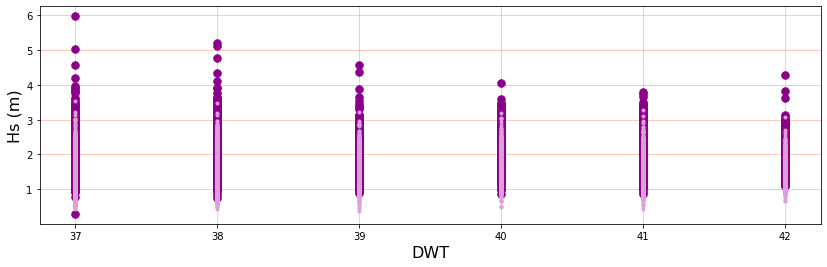

In [13]:
plt.figure(figsize=[14,4])
plt.plot(bmus[s], dataset_nearshore[s,0], '.', markersize=15, color='darkmagenta', label='TC waves')
plt.plot(bmus[s], dataset_nearshore_o[:,0], '.', color='plum', label='No TCs')
plt.ylabel('Hs (m)', fontsize=16)
plt.xlabel('DWT', fontsize=16)
plt.grid('minor', color='coral', alpha=0.5)

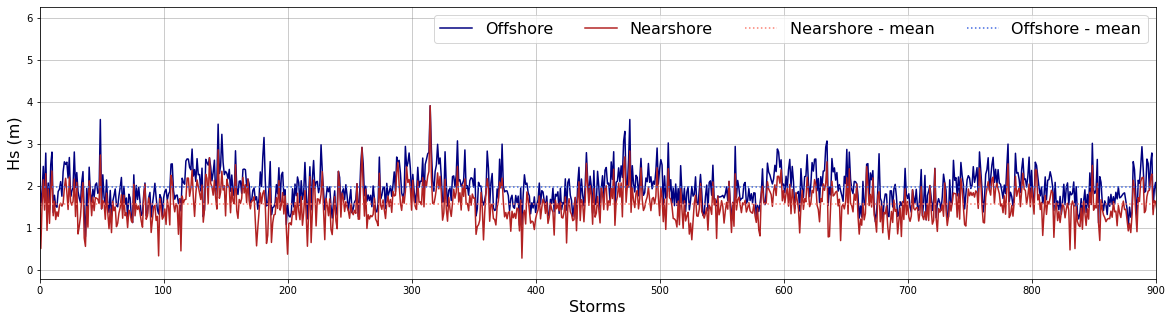

In [14]:
plt.figure(1, figsize=[20,5])
hs_offshore=np.sqrt(dataset[:,0]**2 + dataset[:,1]**2 + dataset[:,2]**2 + dataset[:,3]**2)
plt.plot(hs_offshore, color='navy', label='Offshore')
plt.plot(dataset_nearshore[:,0], color='firebrick', label='Nearshore')
plt.plot([0, len(dataset_nearshore)], [np.nanmean(dataset_nearshore[:,0]), np.nanmean(dataset_nearshore[:,0])], 
         ':', color='salmon', label='Nearshore - mean')
plt.plot([0, len(dataset)], [np.nanmean(hs_offshore), np.nanmean(hs_offshore)], ':', 
         color='royalblue', label='Offshore - mean')
plt.grid(':', color='grey', alpha=0.5)
plt.xlim([0,900]) # Small period to see something
plt.ylabel('Hs (m)', fontsize=16)
plt.xlabel('Storms', fontsize=16)
plt.legend(ncol=4, fontsize=16)

In [15]:
dat_o=xr.open_dataset(op.join(p_data, 'sites' ,'MAJURO-training','Dataset_'+str(nsims)+'simsmaxstorm.nc'))

In [19]:
waves_nearshore = xr.Dataset(
        {
            'Hs': (['time'], dataset_nearshore[:,0]),
            'Tp': (['time'], dataset_nearshore[:,1]),
            'Dir': (['time'], dataset_nearshore[:,2]),
            'msl': (['time'], dat_o['msl']),
            'wind_speed': (['time'], dat_o['wind_speed'].values),
            'wind_dir': (['time'], dat_o['wind_dir'].values),
            'tau': (['time'], dat_o['tau'].values),
            'mu': (['time'], dat_o['mu'].values),
            'ss': (['time'], lvel)
            
        },
        coords={
            'time': dat_o.Time.values.astype('int'),
        },
    )
waves_nearshore

<xarray.Dataset>
Dimensions:     (time: 285199)
Coordinates:
  * time        (time) int64 48 144 24 24 24 96 24 72 ... 96 24 24 24 24 48 0
Data variables:
    Hs          (time) float64 2.032 0.5038 1.54 2.146 ... 1.773 1.715 1.485
    Tp          (time) float64 10.21 13.18 10.2 7.63 ... 5.507 10.89 11.21 11.09
    Dir         (time) float64 67.99 68.1 74.16 48.95 ... 21.35 94.9 62.76 79.31
    msl         (time) float64 1.009e+05 1.01e+05 ... 1.009e+05 1.007e+05
    wind_speed  (time) float64 4.053 2.102 5.231 9.414 ... 4.503 2.054 8.871
    wind_dir    (time) float64 65.8 101.6 109.7 11.41 ... 75.92 79.81 68.83
    tau         (time) float64 0.0 1.0 0.04167 0.1146 ... 0.02083 0.04167 0.375
    mu          (time) float64 0.0 0.9261 0.7949 0.833 ... 0.7947 0.9258 0.9475
    ss          (time) float64 0.6482 0.5528 0.4641 ... 0.3854 0.3379 0.4693

In [31]:
waves_nearshore.to_netcdf('Nearshore_waves_p5.nc')